# --

## Setup

* IMPORT

In [1]:
import keras
import numpy as np
from numpy import ma
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import  classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import random

* Set random state

In [ ]:
random_state = 42

# Data

* LOAD DATA

In [2]:
# Load all data and labels
ccFieldsAll = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/ccLastImageNoCloudIndex0_6234.npy", allow_pickle=True)
labels = np.load("C:/Users/mkoli/Syddansk Universitet/Morten Thyrring Stouenberg - Speciale2023/Data/AllNoAlt/reLabelsAll.npy", allow_pickle=True)

# Cloud probability band subset
cloud_probability = ccFieldsAll[:len(labels),:,:,7]

# Subset data to true labels
ccFieldsAll = ccFieldsAll[:len(labels),:,:,[2,1,0]]

* Normalize color bands

In [3]:
# Initiate function to normalize color bands to fit the preprocessing functions for tensorflow applications transfer learning models
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return (((band-band_min)/((band_max - band_min)))*255)

# We use function for the visible bands - RGB
ccFieldsAll[:,:,:,0] = normalize(ccFieldsAll[:,:,:,0])
ccFieldsAll[:,:,:,1] = normalize(ccFieldsAll[:,:,:,1])
ccFieldsAll[:,:,:,2] = normalize(ccFieldsAll[:,:,:,2])

* Cloud masking

In [4]:
# We Set cloud tolerance, between 0-255
cloud_tolerance = 40
    
# We loop in the fields by the length of the dataset
for i in range(len(ccFieldsAll)):
    # we subset the image we are at in the loop
    image = ccFieldsAll[i,:,:,:]    
    # We create and apply a mask based on cloud probability over a certain value
    # We use np.logical because np.where did not work for me at the moment
    mask = np.logical_and(cloud_probability[i, :, :,] >= cloud_tolerance, cloud_probability[i, :, :] <= 256)
    # We set all masked pixels to zero, to black out cloud covered parts
    # I do not know why but it didn't work when i did not make a copy. It is just one of those times. 
    masked = image.copy()
    masked[mask] = 0
    # We are replacing the current image with the one with applied cloud mask, if no clouds then nothing is removed.
    ccFieldsAll[i] = masked

* DELETE EMPTY IMAGES AND RESIZE

In [5]:
# we want to delete the all black images, this is done by only appending images with visible RGB bands not all black.

# Initiate list for images that did not get blacked out as well as a list for labels
ccFieldsNoCloud = []
LabelsNoCloud = []

# as we are looping in the images we resize them at the same time
# so we set the size of the images
size = 128

# We loop in all the images
for i in range(len(ccFieldsAll)):
    # if the image is not all black
    if not np.all(ccFieldsAll[i] == 0):
        #we append the image and label
        ccFieldsNoCloud.append(tf.image.resize(ccFieldsAll[i], [size, size]))
        LabelsNoCloud.append(labels[i])

# We set the lists as arrays
ccFieldsNoCloud = np.array(ccFieldsNoCloud)
LabelsNoCloud   = np.array(LabelsNoCloud)

#And print the shapes to control the output and see how many fields are left. 
print(ccFieldsNoCloud.shape)
print(LabelsNoCloud.shape)

(6122, 128, 128, 3)
(6122,)


* NEW DISTRIBUTION OF LABELS

In [6]:
#We investigate the new label distribution
print(f'Number of observations : {len(LabelsNoCloud)}')
# We count non zero indices and compute the percentage representation in the dataset. 
print(f'appearances of 0 in labels : {np.count_nonzero(LabelsNoCloud == 0)}({round(100*np.count_nonzero(LabelsNoCloud == 0)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(LabelsNoCloud == 1)}({round(100*np.count_nonzero(LabelsNoCloud == 1)/len(LabelsNoCloud),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(LabelsNoCloud == 2)}({round(100*np.count_nonzero(LabelsNoCloud == 2)/len(LabelsNoCloud),2)}% of total)')

Number of observations : 6122
appearances of 0 in labels : 999(16.32% of total)
appearances of 1 in labels : 1325(21.64% of total)
appearances of 2 in labels : 3798(62.04% of total)


### CNN (RGB images)

In [7]:
# Data is split 80/20 for train and test
X_train, X_test, y_train, y_test = train_test_split(ccFieldsNoCloud, 
                                                    LabelsNoCloud, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

# Train data is split 75/25, which corresponds to 20% of original 
# data as validation and 60% of original data as train
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=random_state) # 0.25 x 0.8 = 0.2

# Print the dataset shapes to inspect sizes
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3672, 128, 128, 3) (3672,)
(1225, 128, 128, 3) (1225,)
(1225, 128, 128, 3) (1225,)


# Data augmentation

In [8]:
#Defining augmentaation method 
 
datagen = ImageDataGenerator(
    # Rotation range is set to 360 to enable images to get any rotational angle
    rotation_range      = 360,        
    # Zoom range is a conservative 0.2 to not get too big parts of the image out of bounds
    zoom_range          = 0.2,           
    # Brightness range is random between specified values to enable brightness adjustment due to sun or shadow from clouds
    brightness_range    = (0.8,1.2),    
    # Horisontal flip is enabled. I do not know if it is going to make a difference, but it is not going to hurt. 
    horizontal_flip     = True)

In [9]:
# We initiate lists for data and labels used for augmentation
data_for_augmentation = []
labels_for_augmentation = []

# We Loop Loop data and append fields to each class for single class data augmentation 
for i in range(len(y_train)):
  if y_train[i] == 0:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])
  if y_train[i] == 1:
    data_for_augmentation.append(X_train[i])
    labels_for_augmentation.append(y_train[i])

# save as numpy arrays
data_for_augmentation    = np.asarray(data_for_augmentation)
labels_for_augmentation    = np.asarray(labels_for_augmentation)

# Check  array shape
print(f'data for augmentation : {data_for_augmentation.shape} labels for augmentation : {labels_for_augmentation.shape}')

data for augmentation : (1412, 128, 128, 3) labels for augmentation : (1412,)


In [10]:
# We set a specified number of images for augmentation per image in the dataset
num_samples_per_image = 7
# num_samples_per_image = 9
# num_samples_per_image = 11

# We reshaping data, i am not sure why, but stack overflow helped me get here.
aug_dataset            = data_for_augmentation.reshape(data_for_augmentation.shape[0], 
                                                      data_for_augmentation.shape[1], 
                                                      data_for_augmentation.shape[2], 
                                                      3)

# We initiate a list of labels for augmented data
labels_aug = []
# We create an empty list for the augmented images
augmented_images = []

# We loop in the length of the dataset
for i in range(len(aug_dataset)):
    # We loop in the desired amount of images augmented for each image
    for j in range(num_samples_per_image):
        # we subset the image
        img = data_for_augmentation[i]
        # we expand dimensions as described on the tensorflow website 
        # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 
        img = np.expand_dims(img, axis=0)
        # We use the datagen.flow to flow one image at the time into the augmenting imagedatagenerator
        # I am not entirely sure about the .next when using only one image but it works, in theory we do not need it but i do not want to remove something when it works. 
        augmented_img = datagen.flow(img, batch_size=1, shuffle=False).next()
        #as we have expanded the dimensiong we need to sqeeze it all back together for a functioning image again
        augmented_img = augmented_img.squeeze(axis=0)
        # We append the image and labels to our lists
        augmented_images.append(augmented_img)
        labels_aug.append(labels_for_augmentation[i])

#Turn it all into numpy arrays
labels_aug=np.asarray(labels_aug)
augmented_images=np.asarray(augmented_images)

In [11]:
# We concatenate the training data and the augmented data.
X_trainx = np.concatenate((X_trainx, augmented_images), axis=0)
y_train = np.concatenate((y_train, labels_aug), axis=0)

In [12]:
# We shuffle the data to ensure there is not only accepted fields in the start of the dataset
# we set a list of indexes that is randomly shuffled
idx = np.random.permutation(len(X_train))
# We use these indexes to set the images with corresponding labels
X_train,y_train = X_train[idx], y_train[idx]

In [13]:
# again we print the distribution to see if it changed - and it did!
print(f'Number of observations : {len(y_train)}')

print(f'appearances of 0 in labels : {np.count_nonzero(y_train == 0)}({round(100*np.count_nonzero(y_train == 0)/len(y_train),2)}% of total)')
print(f'appearances of 1 in labels : {np.count_nonzero(y_train == 1)}({round(100*np.count_nonzero(y_train == 1)/len(y_train),2)}% of total)')
print(f'appearances of 2 in labels : {np.count_nonzero(y_train == 2)}({round(100*np.count_nonzero(y_train == 2)/len(y_train),2)}% of total)')

Number of observations : 13556
appearances of 0 in labels : 4832(35.64% of total)
appearances of 1 in labels : 6464(47.68% of total)
appearances of 2 in labels : 2260(16.67% of total)


# Accuracy metrics function

* Function for classification report and confusion matrix

In [14]:
# We define a function that visualize the results by a classification report and a confusion matrix.

def model_metrics(model, x_test, y_test):
    # Generate predictions on the test set using model and test data.
    y_pred = model.predict(X_test)
    # We use argmax function to gain the predicted class from the probabilities. 
    y_pred_classes = np.argmax(y_pred, axis=1)
    # We print classification report using true labels and predicted labels
    print(classification_report(y_test, y_pred_classes))
    # We Generate a confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    # We define define the class labels
    class_names = ['Failed (0)', 'Partially (1)', 'Accepted (2)']
    # We Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    # show confusion matrix, cmap is the color scheme for matplotlib
    plt.imshow(cm, cmap=plt.cm.OrRd)
    # we set title and labels for plot
    plt.title(f'Confusion Matrix \n {cp_filepath}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # we set ticks
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    # We add labels to the plot
    for k in range(len(class_names)):
        for h in range(len(class_names)):
            plt.text(h, k, cm[k, h], ha='center', va='center', color='black')
    plt.show()

# Training histories

In [15]:
histories = []
name = []

ft_histories = []
ft_name = []

# Best model runs for comparison

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 23s 31ms/step - loss: 2.3298 - accuracy: 0.4664 - val_loss: 2.0500 - val_accuracy: 0.2898
Epoch 2/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0620 - accuracy: 0.5075 - val_loss: 1.3303 - val_accuracy: 0.4482
Epoch 3/100
424/424 [==============================] - 12s 28ms/step - loss: 1.0931 - accuracy: 0.5129 - val_loss: 2.1113 - val_accuracy: 0.2302
Epoch 4/100
424/424 [==============================] - 12s 29ms/step - loss: 1.1117 - accuracy: 0.5139 - val_loss: 1.1651 - val_accuracy: 0.5167
Epoch 5/100
424/424 [==============================] - 12s 28ms/step - loss: 1.1526 - accuracy: 0.5167 - val_loss: 2.1605 - val_accuracy: 0.3322
Epoch 6/100
424/424 [==============================] - 12s 28ms/step - loss: 1.2390 - accuracy: 0.5135 - val_loss: 1.3627 - val_accuracy: 0.5127
Epoch 7/100
424/424 [============================

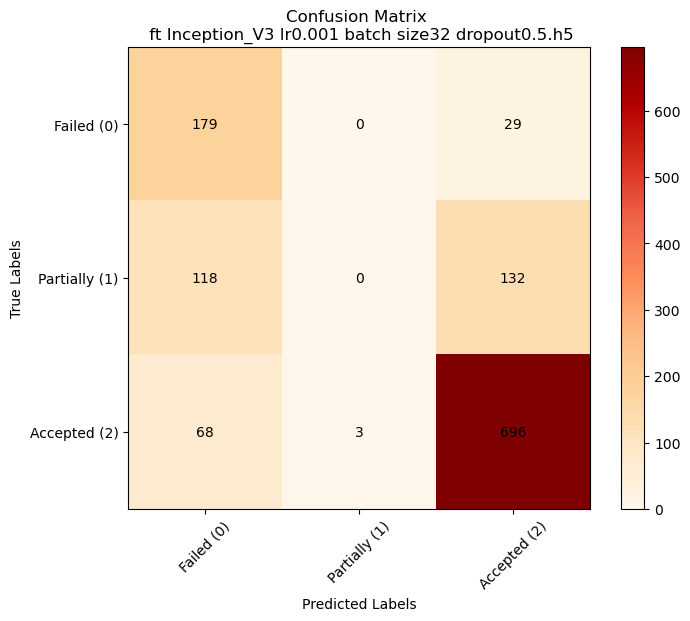

In [16]:
#Inception model
X_train = tf.keras.applications.inception_v3.preprocess_input(X_train, data_format=None)
X_test = tf.keras.applications.inception_v3.preprocess_input(X_test, data_format=None)
X_val = tf.keras.applications.inception_v3.preprocess_input(X_val, data_format=None)

####################################################################################################################
# All steps are specifically the same as in the VGG19 notebook
learning_rate = [0.001]
batch_size = [32]
dropouts = [0.5]
model_name = "Inception_V3" 
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)
####################################################################################################################
for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')
            ####################################################################################################################
            base_model = keras.applications.InceptionV3(weights='imagenet', 
                                                  input_shape=input_shape,
                                                  include_top=False,
            ) 
            ####################################################################################################################
            base_model.trainable = False
            ####################################################################################################################
            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])   
            ####################################################################################################################
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
            ####################################################################################################################
            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            ####################################################################################################################
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')      
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')
            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)
            model = tf.keras.models.load_model(cp_filepath)
            model_metrics(model, X_test, y_test)

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 16s 31ms/step - loss: 1.5686 - accuracy: 0.4084 - val_loss: 2.7385 - val_accuracy: 0.1527
Epoch 2/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0866 - accuracy: 0.4330 - val_loss: 1.9490 - val_accuracy: 0.2204
Epoch 3/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0597 - accuracy: 0.4416 - val_loss: 1.6951 - val_accuracy: 0.2196
Epoch 4/100
424/424 [==============================] - 12s 28ms/step - loss: 1.0619 - accuracy: 0.4411 - val_loss: 1.9244 - val_accuracy: 0.2204
Epoch 5/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0628 - accuracy: 0.4464 - val_loss: 1.0218 - val_accuracy: 0.4261
Epoch 6/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0737 - accuracy: 0.4437 - val_loss: 1.2009 - val_accuracy: 0.2914
Epoch 7/100
424/424 [============================

c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


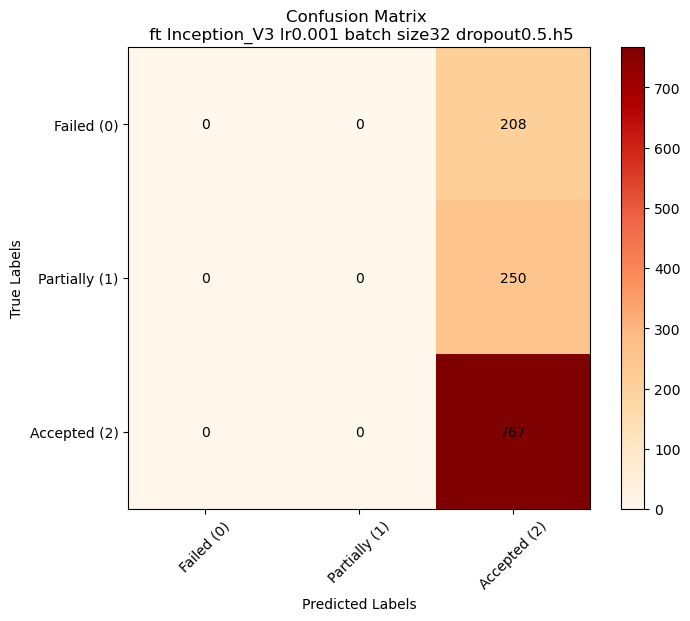

In [17]:
####################################################################################################################
# All steps are the same as above, we change the model and top layers for specific model
learning_rate = [0.001]
batch_size = [32]
dropouts = [0.5]
model_name = "Inception_V3" 
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)
####################################################################################################################
for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')
            ####################################################################################################################
            base_model = keras.applications.InceptionV3(weights='imagenet', 
                                                  input_shape=input_shape,
                                                  include_top=False,
            ) 
            ####################################################################################################################
            base_model.trainable = False
            ####################################################################################################################
            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])   
            ####################################################################################################################
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
            ####################################################################################################################
            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            ####################################################################################################################
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')      
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')
            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)
            model = tf.keras.models.load_model(cp_filepath)
            model_metrics(model, X_test, y_test)

Running: 
 learning rate:0.001, batch size: 32 with dropout: 0.5 for epochs: 100
Epoch 1/100
424/424 [==============================] - 16s 31ms/step - loss: 1.5428 - accuracy: 0.4049 - val_loss: 1.1206 - val_accuracy: 0.1657
Epoch 2/100
424/424 [==============================] - 12s 29ms/step - loss: 1.1279 - accuracy: 0.4222 - val_loss: 1.3458 - val_accuracy: 0.2180
Epoch 3/100
424/424 [==============================] - 12s 28ms/step - loss: 1.0659 - accuracy: 0.4405 - val_loss: 1.7760 - val_accuracy: 0.2180
Epoch 4/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0595 - accuracy: 0.4410 - val_loss: 1.1939 - val_accuracy: 0.2180
Epoch 5/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0606 - accuracy: 0.4402 - val_loss: 1.6575 - val_accuracy: 0.1527
Epoch 6/100
424/424 [==============================] - 12s 29ms/step - loss: 1.0679 - accuracy: 0.4433 - val_loss: 1.5564 - val_accuracy: 0.2180
Epoch 7/100
424/424 [============================

c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mkoli\anaconda3\envs\tfspeciale\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


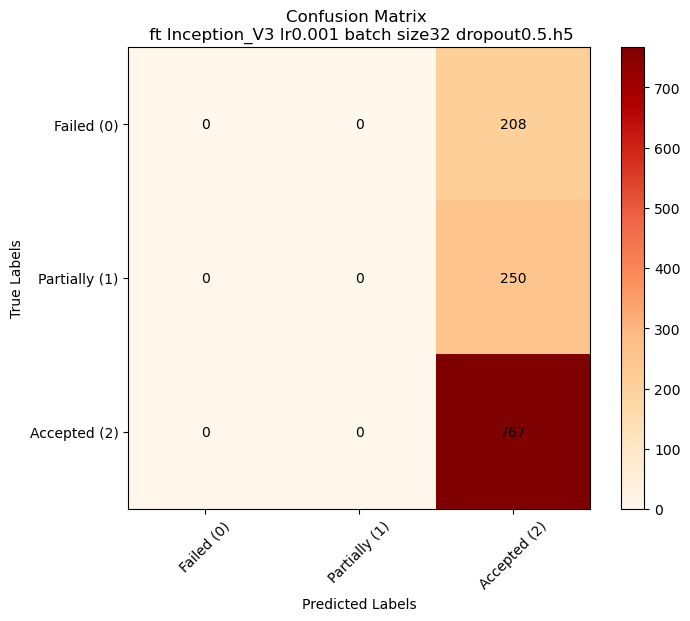

In [18]:
####################################################################################################################
# All steps are the same as above, we change the model and top layers for specific model
learning_rate = [0.001]
batch_size = [32]
dropouts = [0.5]
model_name = "Inception_V3" 
epochs = 100
finetune_epochs = 30
num_classes = 3
input_shape = (128, 128, 3)
####################################################################################################################
for i in learning_rate:
    for j in batch_size:
        for d in dropouts:
            ####################################################################################################################
            print(f'Running: \n learning rate:{i}, batch size: {j} with dropout: {d} for epochs: {epochs}')
            ####################################################################################################################
            base_model = keras.applications.InceptionV3(weights='imagenet', 
                                                  input_shape=input_shape,
                                                  include_top=False,
            ) 
            ####################################################################################################################
            base_model.trainable = False
            ####################################################################################################################
            model = tf.keras.Sequential([
                base_model,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(2048, activation='linear'),  
                tf.keras.layers.Dropout(d),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])   
            ####################################################################################################################
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
            ####################################################################################################################
            cp_filepath = '{} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')
            ####################################################################################################################
            history = model.fit(X_train, y_train, batch_size=j, epochs=epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            histories.append(history)
            name.append(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            ####################################################################################################################
            model = tf.keras.models.load_model(cp_filepath)
            model.trainable = True
            model.summary()
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
            cp_filepath = 'ft {} lr{} batch size{} dropout{}.h5'.format(model_name, i,j,d)
            checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, 
                                                            monitor='val_accuracy', 
                                                            save_best_only=True, mode='max')      
            checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_filepath, monitor='val_accuracy', save_best_only=True, mode='max')
            history = model.fit(X_train, y_train, batch_size=j, epochs=finetune_epochs, validation_data=(X_val, y_val), callbacks=[checkpoint])
            ft_histories.append(history)
            ft_name.append(cp_filepath)
            model = tf.keras.models.load_model(cp_filepath)
            model_metrics(model, X_test, y_test)

# Comparison of best model metrics

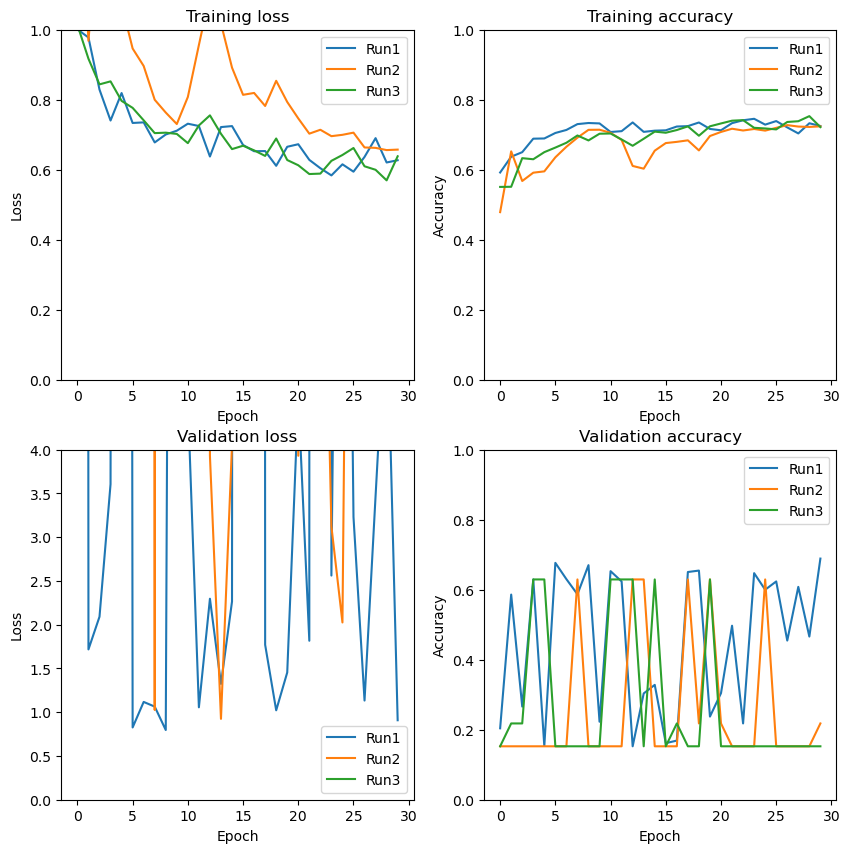

In [21]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(ft_histories[0].history['loss'], label='Run1')
ax.plot(ft_histories[1].history['loss'], label='Run2')
ax.plot(ft_histories[2].history['loss'], label='Run3')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(ft_histories[0].history['accuracy'], label='Run1')
ax.plot(ft_histories[1].history['accuracy'], label='Run2')
ax.plot(ft_histories[2].history['accuracy'], label='Run3')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(ft_histories[0].history['val_loss'], label='Run1')
ax.plot(ft_histories[1].history['val_loss'], label='Run2')
ax.plot(ft_histories[2].history['val_loss'], label='Run3')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(ft_histories[0].history['val_accuracy'], label='Run1')
ax.plot(ft_histories[1].history['val_accuracy'], label='Run2')
ax.plot(ft_histories[2].history['val_accuracy'], label='Run3')

plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()

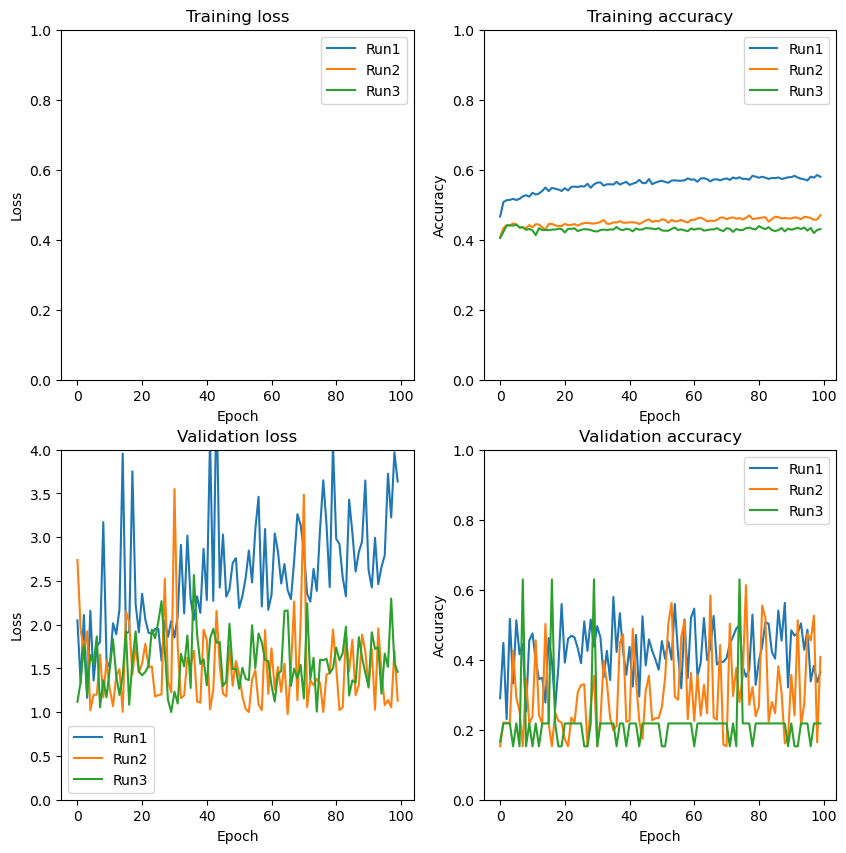

In [22]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=[10, 10])
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(spec2[0,0])
ax.plot(histories[0].history['loss'], label='Run1')
ax.plot(histories[1].history['loss'], label='Run2')
ax.plot(histories[2].history['loss'], label='Run3')
plt.title("Training loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[0,1])
ax.plot(histories[0].history['accuracy'], label='Run1')
ax.plot(histories[1].history['accuracy'], label='Run2')
ax.plot(histories[2].history['accuracy'], label='Run3')
plt.title("Training accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend()

ax = fig.add_subplot(spec2[1,0])
ax.plot(histories[0].history['val_loss'], label='Run1')
ax.plot(histories[1].history['val_loss'], label='Run2')
ax.plot(histories[2].history['val_loss'], label='Run3')


plt.title("Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0,4])
plt.legend()

ax = fig.add_subplot(spec2[1,1])
ax.plot(histories[0].history['val_accuracy'], label='Run1')
ax.plot(histories[1].history['val_accuracy'], label='Run2')
ax.plot(histories[2].history['val_accuracy'], label='Run3')

plt.title("Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend()

plt.savefig('fintuned_metrics.png')
plt.show()